In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

df_webdata = pd.read_csv('df_webdata.csv')


In [3]:
df_webdata

,client_id,visit_id,duration,start,step_1,step_2,step_3,confirm,variation
0,169,749567106_99161211863_557568,00:03:33,1,1,1,1,1,Not participant
1,336,649044751_80905125055_554468,00:15:48,2,0,0,0,0,Not participant
2,546,731811517_9330176838_94847,00:02:13,1,1,1,1,1,Not participant
3,555,637149525_38041617439_716659,00:02:38,1,1,1,1,1,Test
4,647,40369564_40101682850_311847,00:06:17,1,1,1,1,1,Test
...,...,...,...,...,...,...,...,...,...
159107,9999729,99583652_41711450505_426179,00:00:15,1,1,0,0,0,Test
159108,9999768,85676722_11636430786_122704,00:08:06,3,3,3,2,1,Not participant
159109,9999832,472154369_16714624241_585315,00:00:08,1,1,0,0,0,Test
159110,9999839,715530422_68620416793_515645,00:04:08,2,1,1,1,1,Not participant


# DURACIÓN DE LAS SESIONES

In [4]:


# Convertir 'duration' a segundos para facilitar el análisis para cálculos y análisis estadísticos, como promedios o comparaciones.)
df_webdata['duration_seconds'] = pd.to_timedelta(df_webdata['duration']).dt.total_seconds()

# Estadísticas descriptivas generales
print("Estadísticas generales de la duración (en segundos):")
print(df_webdata['duration_seconds'].describe())

# Comparación de duración promedio por grupo de variación
durations_by_group = df_webdata.groupby('variation')['duration_seconds'].mean()
print("\nDuración promedio por grupo:")
print(durations_by_group)


Estadísticas generales de la duración (en segundos):
count    159112.000000
mean        313.011212
std         588.621962
min           0.000000
25%          42.000000
50%         169.000000
75%         357.000000
max       42768.000000
Name: duration_seconds, dtype: float64

Duración promedio por grupo:
variation
Control            280.510653
Not participant    323.683823
Test               315.455999
Name: duration_seconds, dtype: float64


## VISUALIZACIONES DE LA DURACIÓN DE LAS SESIONES

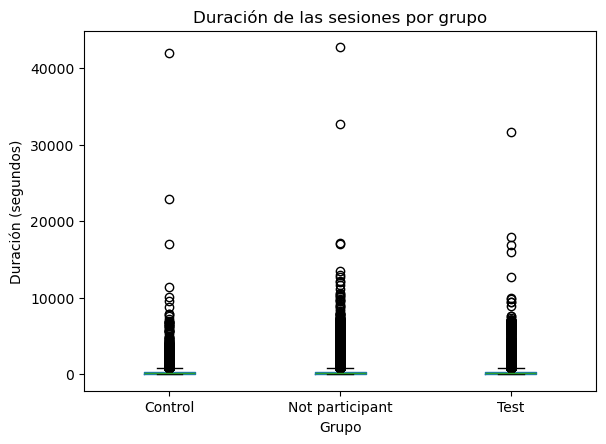

In [5]:
# Visualización de la duración por grupo
df_webdata.boxplot(column='duration_seconds', by='variation', grid=False)
plt.title("Duración de las sesiones por grupo")
plt.xlabel("Grupo")
plt.ylabel("Duración (segundos)")
plt.suptitle("")
plt.show()


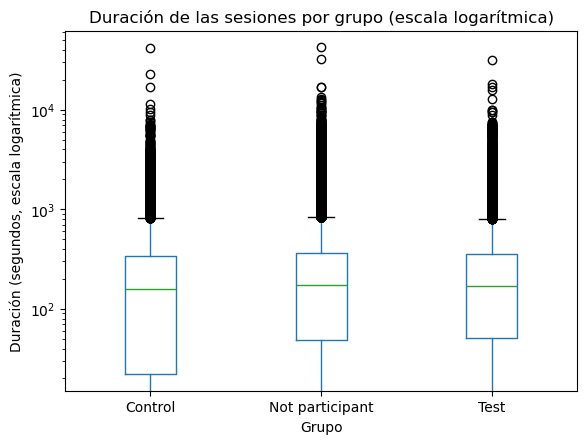

In [6]:
# Boxplot con escala logarítmica
df_webdata.boxplot(column='duration_seconds', by='variation', grid=False)
plt.yscale('log')
plt.title("Duración de las sesiones por grupo (escala logarítmica)")
plt.xlabel("Grupo")
plt.ylabel("Duración (segundos, escala logarítmica)")
plt.suptitle("")
plt.show()


/tmp/ipykernel_7727/332796827.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_distribution = df_webdata.groupby(['variation', 'duration_bins']).size().unstack()


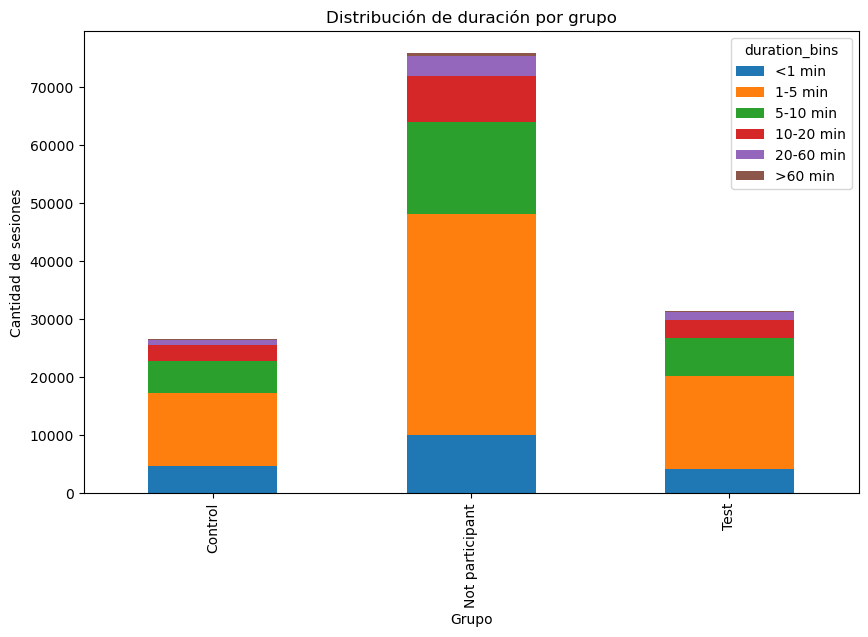

In [7]:
df_webdata['duration_bins'] = pd.cut(df_webdata['duration_seconds'], bins=[0, 60, 300, 600, 1200, 3600, float('inf')],
                                     labels=['<1 min', '1-5 min', '5-10 min', '10-20 min', '20-60 min', '>60 min'])

duration_distribution = df_webdata.groupby(['variation', 'duration_bins']).size().unstack()
duration_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Distribución de duración por grupo")
plt.xlabel("Grupo")
plt.ylabel("Cantidad de sesiones")
plt.show()


# PASOS COMPLETADOS (EN EL TOTAL DE LAS MUESTRAS)

In [8]:
# Sumar la cantidad de usuarios que completaron cada paso
steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
step_counts = df_webdata[steps].sum()
step_percentages = (step_counts / len(df_webdata)) * 100

print("\nPorcentaje de usuarios por paso:")
print(step_percentages)



Porcentaje de usuarios por paso:
start      147.694077
step_1     102.315979
step_2      83.431796
step_3      70.132360
confirm     64.423802
dtype: float64


## VISUALIZACIÓN DE PASOS COMPLETADOS (EN EL TOTAL DE LAS MUESTRAS)

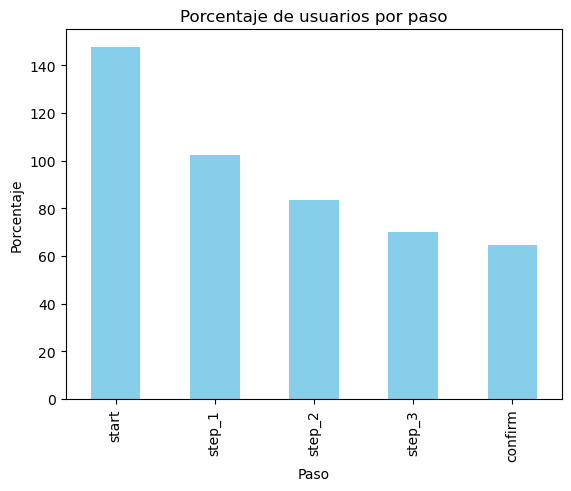

In [9]:
# Visualización del flujo de pasos
step_percentages.plot(kind='bar', color='skyblue')
plt.title("Porcentaje de usuarios por paso")
plt.xlabel("Paso")
plt.ylabel("Porcentaje")
plt.show()


## PASOS COMPLETADOS POR GRUPOS

In [10]:
# Crear una columna con el número de pasos completados
df_webdata['steps_completed'] = df_webdata[steps].sum(axis=1)

# Comparar el promedio de pasos completados por grupo
steps_by_group = df_webdata.groupby('variation')['steps_completed'].mean()
print("\nPromedio de pasos completados por grupo:")
print(steps_by_group)



Promedio de pasos completados por grupo:
variation
Control            4.358651
Not participant    4.766698
Test               4.749462
Name: steps_completed, dtype: float64


## VISUALIZACION DE PASOS COMPLETADOS POR GRUPOS

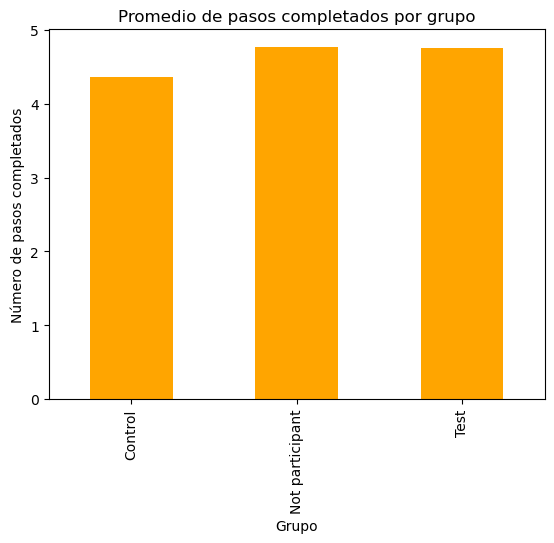

In [11]:

# Visualización
steps_by_group.plot(kind='bar', color='orange')
plt.title("Promedio de pasos completados por grupo")
plt.xlabel("Grupo")
plt.ylabel("Número de pasos completados")
plt.show()


## Prueba estadística
Para verificar si la diferencia en la tasa de finalización entre los grupos es significativa.

(Se hace para los grupos test y control porque solo acepta hacerlo de dos en dos)
(pero se puede hacer también con otros pares de grupos, aunque no sé qué vamos a hacer con el grupo no participant)

In [12]:
from statsmodels.stats.proportion import proportions_ztest

# Filtrar dos grupos específicos
group1 = 'Test'
group2 = 'Control'

# Contar confirmaciones y totales para ambos grupos
confirmations_g1 = df_webdata[df_webdata['variation'] == group1]['confirm'].sum()
confirmations_g2 = df_webdata[df_webdata['variation'] == group2]['confirm'].sum()

totals_g1 = df_webdata[df_webdata['variation'] == group1].shape[0]
totals_g2 = df_webdata[df_webdata['variation'] == group2].shape[0]

# Prueba Z de proporciones entre los dos grupos
stat, p_value = proportions_ztest([confirmations_g1, confirmations_g2], [totals_g1, totals_g2])
print(f"Prueba Z entre {group1} y {group2}:")
print(f"Z-statistic: {stat:.3f}, P-value: {p_value:.3f}")


Prueba Z entre Test y Control:
Z-statistic: 40.696, P-value: 0.000


1. Z-statistic: 40.696

    Interpretación:
        El estadístico Z mide cuántas desviaciones estándar separan las proporciones de los grupos Test y Control.
        Un valor tan alto como 40.696 indica una diferencia extremadamente grande entre las proporciones de confirmación de los dos grupos.
    Signo positivo:
        Esto implica que el grupo Test tiene una proporción de confirmaciones significativamente mayor que el grupo Control.

2. P-value: 0.000

    Interpretación:
        El valor p representa la probabilidad de observar una diferencia tan grande (o mayor) entre las proporciones, si realmente no hubiera diferencia entre los grupos.
        Un p-value de 0.000 (o muy cercano a 0) indica que esta probabilidad es prácticamente inexistente.

    Conclusión:
        Como p<0.05p<0.05 (nivel de significancia típico), rechazamos la hipótesis nula, que asume que las proporciones son iguales.
        Concluimos que las proporciones de confirmación entre los grupos Test y Control son estadísticamente diferentes.

Conclusión General

    El grupo Test tiene una tasa de confirmación mucho mayor que el grupo Control.
    La diferencia observada entre los dos grupos no es atribuible al azar; es estadísticamente significativa.

Implicaciones

Si el grupo Test representa una nueva estrategia o diseño, los resultados sugieren que esta estrategia es altamente efectiva para aumentar las confirmaciones en comparación con el grupo Control.


